# Allen Institute
## 08-1_grn_m1_10x
---
- `../data/m1_10x_resampled/resampled`

1. Data Viz
2. Make GRN
3. Export GRN infomation

In [1]:
import os
from itertools import product
import json
from typing import NamedTuple, Dict, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pyvis.network as pv
import seaborn as sns

from pgmpy.models import BayesianModel
from pgmpy.estimators import PC, MmhcEstimator, HillClimbSearch
from pgmpy.estimators import BicScore


from tools.figure import boxplot, cns_subtype_markers, fig_kwarg
from tools.r import read_json
import tools.spongy_panda as spd

In [2]:
sample_id = "m1_10x"

In [3]:
with open("../data/gene_list.json", "r") as f:
    feat = json.load(f)[sample_id]

feat = [v for v in cns_subtype_markers if v in feat]

In [4]:
class Config(NamedTuple):
    data: pd.core.frame.DataFrame = spd.log2normalize(
        spd.load_10xdir(
            "../data/m1_10x_resampled/resampled", from_r=True
        ).loc[:, feat]
    ).to_df()
    umap: pd.core.frame.DataFrame = pd.read_pickle(
        "../data/m1_10x_viz/umap.pkl"
    )
    sample_id: str = sample_id
    cmap: str = "gist_rainbow"
    save_dir: str = "../out/m1_10x/07_fa"
    fig_kwarg: Dict[str, Union[str, int, float]] = fig_kwarg
    save_file: bool = False

In [5]:
conf = Config(save_file=False)

os.makedirs(conf.save_dir, exist_ok=True)

---
## Data Visualization
- heatmap
- kmo
- histogram

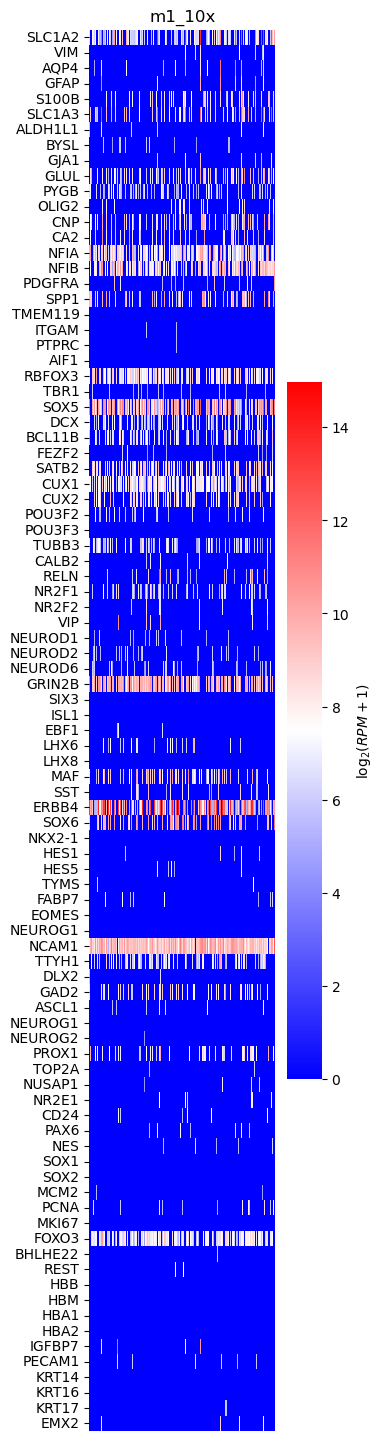

In [6]:
fig, ax = plt.subplots(figsize=(3, 0.2 * conf.data.shape[1]))
sns.heatmap(
    conf.data.T, ax=ax, cmap="bwr",
    vmax=conf.data.max().max(),
    vmin=conf.data.min().min(),
    xticklabels=False
)
ax.set(ylabel="", title=conf.sample_id)
ax.collections[0].colorbar.set_label("$\log_2(RPM+1)$");

if conf.save_file:
    plt.savefig(f"{conf.save_dir}/heatmap.png", **conf.fig_kwarg)